# **Practical Example 1**
## **Semantic Segmentation with tiny encoder-decoder architecture**




### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import random
%matplotlib inline

# reproducibility
np.random.seed(0)

### Installation of the cairo library for creating geometric shapes

In [2]:
# https://pypi.org/project/pycairo/1.16.2/
!apt install libcairo2-dev
!pip install pycairo
import cairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxcb-shm0-dev amd64 1.13-2~ubuntu18.04 [6,684 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo2-dev amd64 1.15.10-2ubuntu0.1 [626 kB]
Fetched 

## Functions for creating and manipulating the dataset (Dataset functions)

In [8]:
def multiple_shape_dataset(num_imgs = 100, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16):

  imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
  masks = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA

  num_shapes = 3
  shape_labels = ['rectangle', 'circle', 'triangle']

  for i_img in range(num_imgs):
    
    # cairo imgs
    surface_img = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_img = cairo.Context(surface_img)
    cr_img.set_source_rgb(0, 0, 0)
    cr_img.paint()

    # cairo mask
    surface_mask = cairo.ImageSurface.create_for_data(masks[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_mask = cairo.Context(surface_mask)
    cr_mask.get_source().set_extend(cairo.EXTEND_REPEAT)

    cr_mask.set_source_rgb(0, 0, 0)
    cr_mask.paint()

    # Draw random shapes.
    for i_object in range(num_objects):
      shape = np.random.randint(num_shapes)

      if shape == 0:  # rectangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.rectangle(x, y, w, h)
          cr_img.set_source_rgb(0.5, 0.1, 0.1) # red
          #cr_img.set_source_rgb(round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10)) # random

      elif shape == 1:  # circle   
          r = 0.5 * np.random.randint(min_object_size, max_object_size)
          x = np.random.randint(r, img_size - r)
          y = np.random.randint(r, img_size - r)

          cr_img.arc(x, y, r, 0, 2*np.pi)
          cr_img.set_source_rgb(0.1, 0.5, 0.1) # green
          #cr_img.set_source_rgb(round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10)) # random

      elif shape == 2:  # triangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.move_to(x, y)
          cr_img.line_to(x+w, y)
          cr_img.line_to(x+w, y+h)
          cr_img.line_to(x, y)
          cr_img.close_path()

          cr_img.set_source_rgb(0.1, 0.1, 0.5) # blue
          #cr_img.set_source_rgb(round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10), round(random.uniform(0.1, 1.0), 10)) # random

      cr_img.fill()

  imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB
  masks = getImageLabels(imgs) # generations of masks from images
  imgs = normalize_dataset(imgs) # normalization of pixels values

  return imgs, masks

In [9]:
# labels to one-hot encoding
def getImageLabels(masks):
    
    labels = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], 4), dtype=np.uint8)

    for i in range(0, masks.shape[0]):
      
      mask_0 = (masks[i] == [  0,  0,  0]).all(axis=2) # backgroud = 0
      mask_1 = (masks[i] >  [100,  0,  0]).all(axis=2) # rectangle = 1
      mask_2 = (masks[i] >  [  0,100,  0]).all(axis=2) # circle    = 2
      mask_3 = (masks[i] >  [  0,  0,100]).all(axis=2) # triangle  = 3
      
      labels[i][mask_0, 0] = 1
      labels[i][mask_1, 1] = 1 
      labels[i][mask_2, 2] = 1
      labels[i][mask_3, 3] = 1
      
    return labels

In [10]:
def normalize_dataset(imgs):
  X = imgs / 255.
  return X

In [11]:
def split_dataset(X, y, train_ratio = 0.8):
  num_imgs = X.shape[0]
  i = int(train_ratio * num_imgs)
  train_X = X[:i]
  test_X = X[i:]
  train_y = y[:i]
  test_y = y[i:]
  return train_X, test_X, train_y, test_y

### Helper functions

In [12]:
def show_image(img):
  plt.figure(figsize=(8,4))
  plt.subplot(1, 2, 1)
  img_size = imgs[0].shape[0]
  plt.imshow(img, interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

def display_mask(mask):
  mask = np.argmax(mask, axis=-1) # (32, 32, n_classes) > (32, 32)
  plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

def display(imgs, masks):
  img_size = imgs[0].shape[0]
  plt.figure(figsize=(16, 8))

  for i, i_subplot in enumerate(range(1, 5)):
    plt.subplot(2, 4, i_subplot)
    plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

  for i, i_subplot in enumerate(range(5, 9)): 
    plt.subplot(2, 4, i_subplot)
    mask = np.argmax(masks[i], axis=-1) 
    plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

    plt.axis('off')

  plt.show()

In [13]:
# create dataset
imgs, masks = multiple_shape_dataset(num_imgs = 5000, num_objects = 8, img_size = 64, min_object_size = 8, max_object_size = 20)

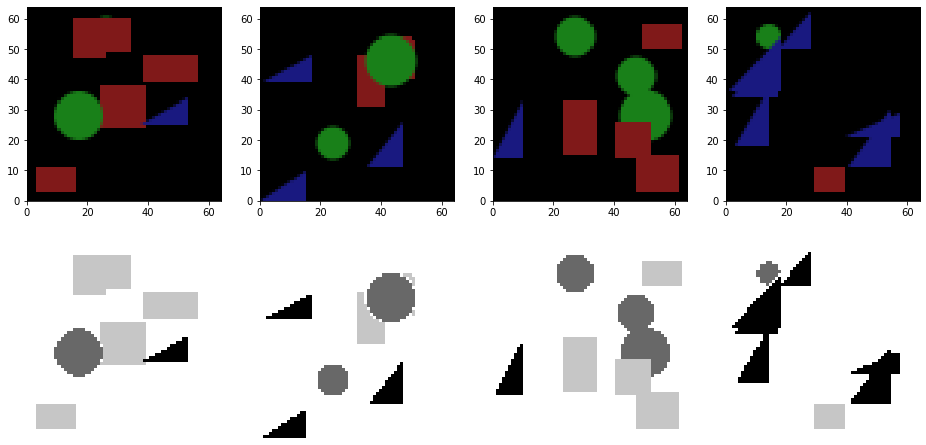

In [14]:
display(imgs, masks)

## Model definition and configuration

In [15]:
# import libs
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Convolution2D, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Reshape, Lambda, concatenate

import keras.backend as K
K.backend()

'tensorflow'

In [16]:
#build the model
def model_segmentation(img_shape):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', input_shape=img_shape, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2))),

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))

    ###################################################################################
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    ###################################################################################

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same')),
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))

    model.add(Conv2D(filters=train_y.shape[-1], kernel_size=(3, 3), activation='softmax', padding='same'))
    # model.summary()

    return model

# **Dataset creation**

In [17]:
# holdout: 0.8 for training
train_X, test_X, train_y, test_y = split_dataset(imgs, masks)
train_X.shape, train_y.shape

((4000, 64, 64, 3), (4000, 64, 64, 4))

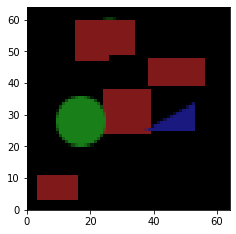

In [18]:
index = 0
show_image(imgs[index])

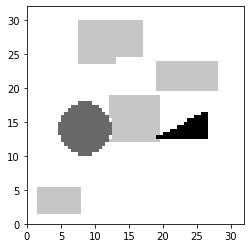

In [19]:
display_mask(masks[index])

# **Training model**

In [28]:
from keras import metrics
model = model_segmentation(train_X.shape[1:])
model.compile('sgd', 'categorical_crossentropy', metrics=['accuracy'])
model_h = model.fit(train_X, train_y, epochs=5, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/5
125/125 [==============================] - 229s 2s/step - loss: 0.7160 - accuracy: 0.7872 - val_loss: 0.3562 - val_accuracy: 0.8431
Epoch 2/5
125/125 [==============================] - 227s 2s/step - loss: 0.3233 - accuracy: 0.8556 - val_loss: 0.3055 - val_accuracy: 0.8836
Epoch 3/5
125/125 [==============================] - 227s 2s/step - loss: 0.2716 - accuracy: 0.8983 - val_loss: 0.2138 - val_accuracy: 0.9202
Epoch 4/5
125/125 [==============================] - 227s 2s/step - loss: 0.1713 - accuracy: 0.9266 - val_loss: 0.1393 - val_accuracy: 0.9324
Epoch 5/5
125/125 [==============================] - 227s 2s/step - loss: 0.1272 - accuracy: 0.9449 - val_loss: 0.1058 - val_accuracy: 0.9591


# **Prediction and Evaluation**

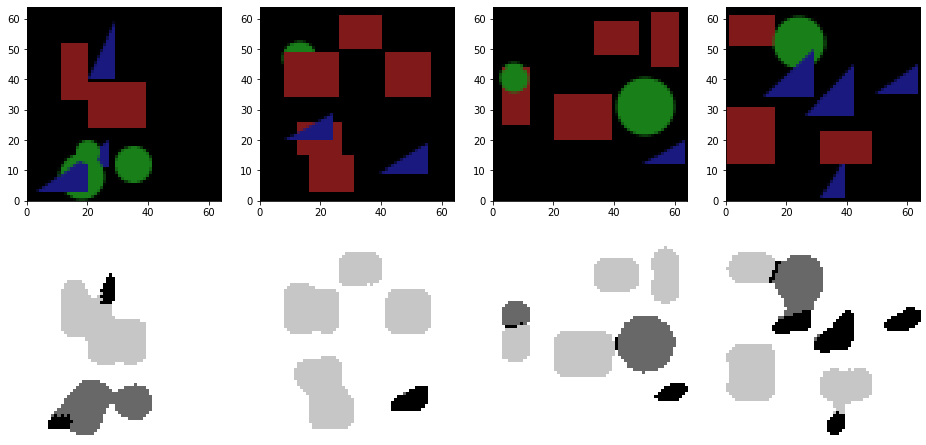

In [29]:
test_y_predicted = model.predict(test_X)

display(test_X, test_y_predicted)

# ASSIGNMENT

- Adicionar camadas na rede! -Ok
- Modificar os parâmetros do dataset! -Ok
- randomizar as cores dos objetos! -ok (neste caso, devido a grande possíbilidade de cores, o modelo acabou se perdendo).

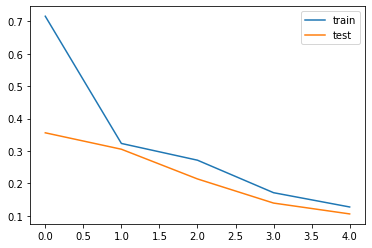

In [33]:
import matplotlib.pyplot as plt
plt.plot(model_h.history['loss'], label='train')
plt.plot(model_h.history['val_loss'], label='test')
plt.legend()

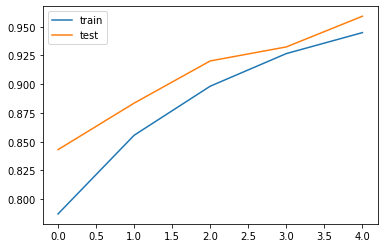

In [34]:
plt.plot(model_h.history['accuracy'], label='train')
plt.plot(model_h.history['val_accuracy'], label='test')
plt.legend()